# Sampling MNIST images

In [1]:
using MLDatasets
using OneHotArrays
preprocess((x, y)) = reshape(x, 28, 28, 1, :), onehotbatch(y, 0:9)
xtrain, ytrain = preprocess(MLDatasets.MNIST(:train)[1:50]);

In [2]:
include("plotimages.jl")

    CondaPkg Found dependencies: /home/kenta/.julia/packages/PythonCall/dsECZ/CondaPkg.toml
    CondaPkg Found dependencies: /home/kenta/.julia/packages/PythonPlot/f591M/CondaPkg.toml
    CondaPkg Dependencies already up to date


plotimages (generic function with 1 method)

## Forward diffusion

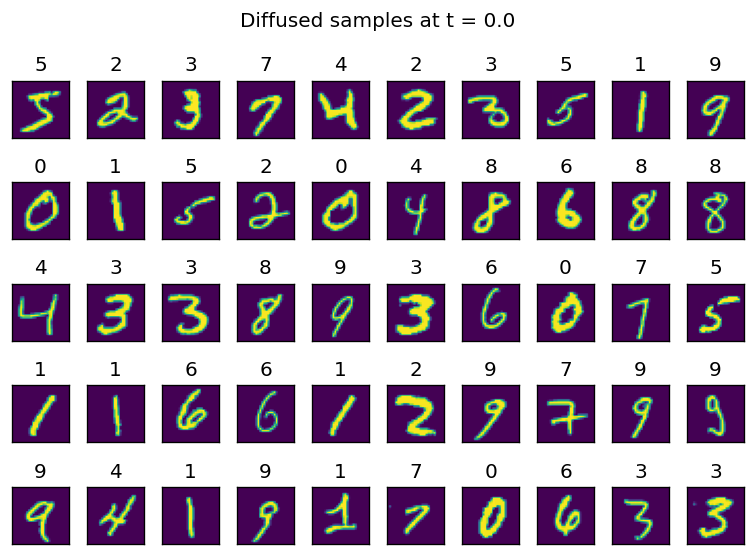

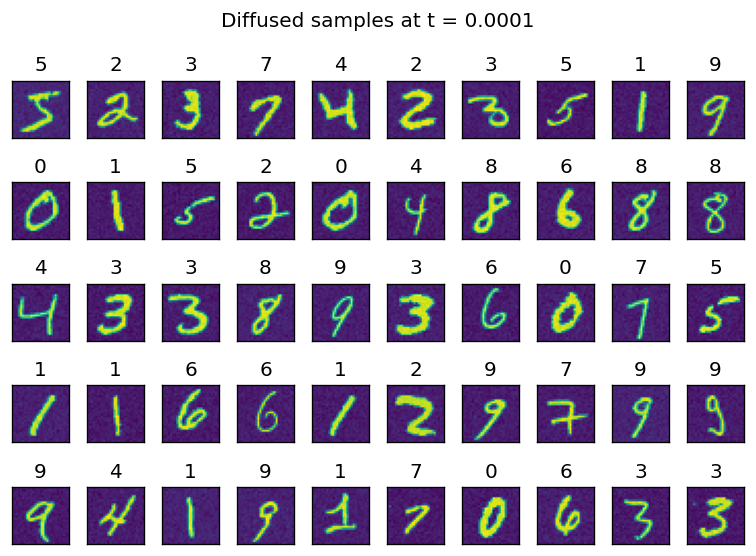

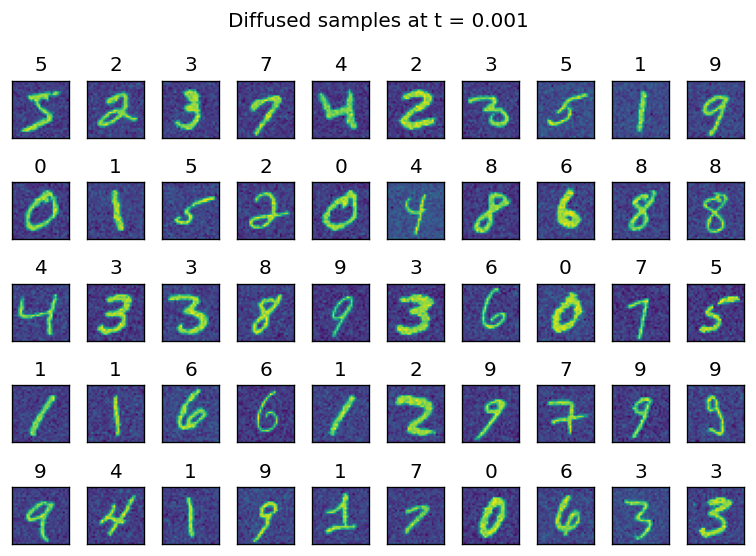

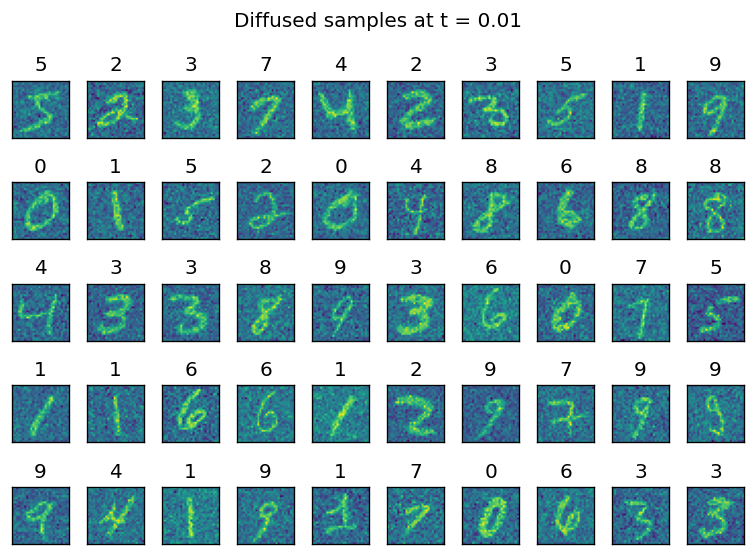

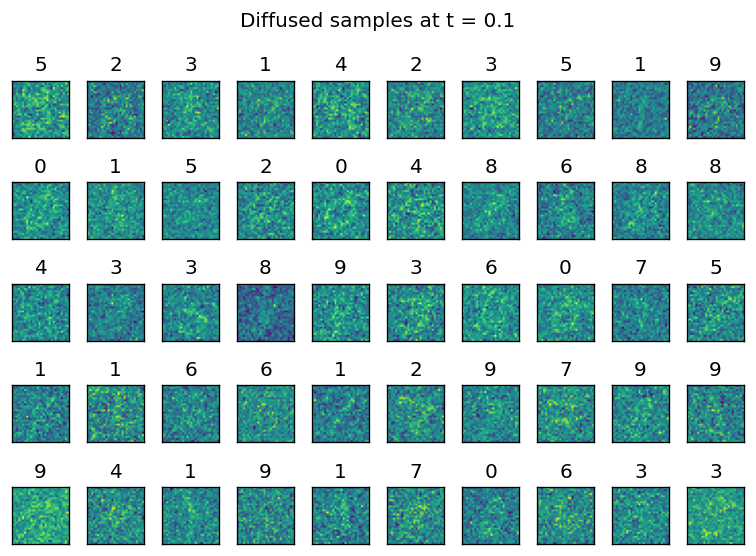

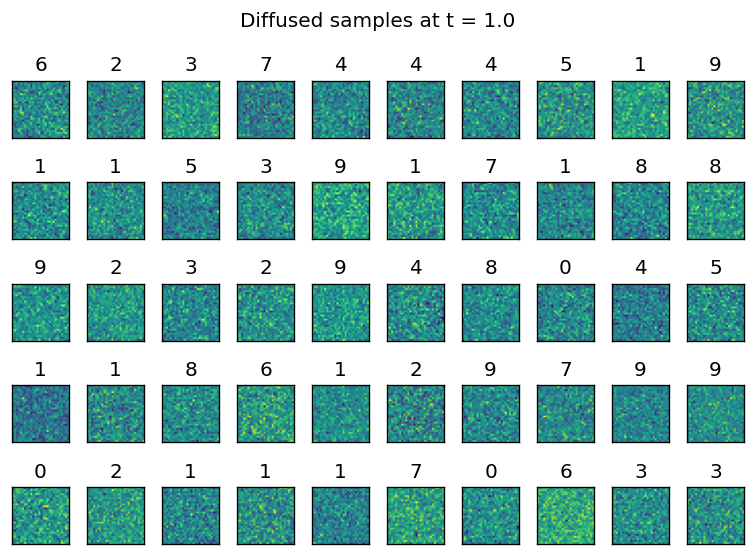

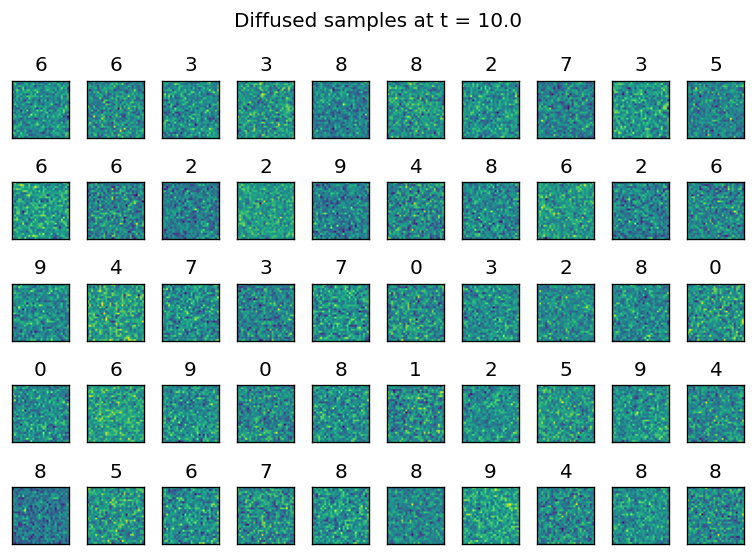

In [3]:
using Diffusions
using Random

rng = Xoshiro(1234)
θ = 4.0f0  # reversion
σ = √(2θ)  # volatility
diffusion = (OrnsteinUhlenbeckDiffusion(0, σ, θ), UniformDiscreteDiffusion(0.5f0, 10))
for t in Float32[0.0, 0.0001, 0.001, 0.01, 0.1, 1.0, 10.0]
    x, y = sampleforward(rng, diffusion, t, (xtrain, onecold(ytrain)))
    plotimages(x, y .- 1, "Diffused samples at t = $t")
end

In [4]:
timesteps = timeschedule(exp10, 1f-4, 1f+1, 301)

301-element Vector{Float32}:
  0.0001
  0.00010391223
  0.00010797751
  0.00011220183
  0.00011659142
  0.00012115274
  0.00012589252
  0.00013081772
  0.00013593567
  0.00014125378
  0.00014677996
  0.00015252232
  0.00015848933
  ⋮
  6.5564184
  6.8129206
  7.079458
  7.356423
  7.6442227
  7.943282
  8.254043
  8.576959
  8.912509
  9.261187
  9.623507
 10.0

In [5]:
using BSON: @load
include("model.jl")
@load "mnist-500.bson" unet

## Backward denoising

In [6]:
# See the following paper for self-conditioning:
# Chen, Ting, Ruixiang Zhang, and Geoffrey Hinton. "Analog bits: Generating
# discrete data using diffusion models with self-conditioning." arXiv preprint
# arXiv:2208.04202 (2022).
function selfconditioned_guess(x)
    x_0 = zero(x)
    function guess((x_t, y_t), t)
        x̂, ŷ = unet(cat(x_t, x_0, dims = 3), onehotbatch(y_t, 1:10), fill(t, size(y_t, 2)))
        #ŷ[8,:] .+= 100  # encourage to generate images of a specific class
        x_0 = sigmoid.(x̂)
        return x_0, randcat(softmax(ŷ, dims = 1))
    end
end

rng = Xoshiro(1234)
x = randn(rng, Float32, (28, 28, 1, 50))
y = rand(rng, 1:10, 50)
x_0, y_0 = samplebackward(rng, selfconditioned_guess(x), diffusion, timesteps, (x, y));

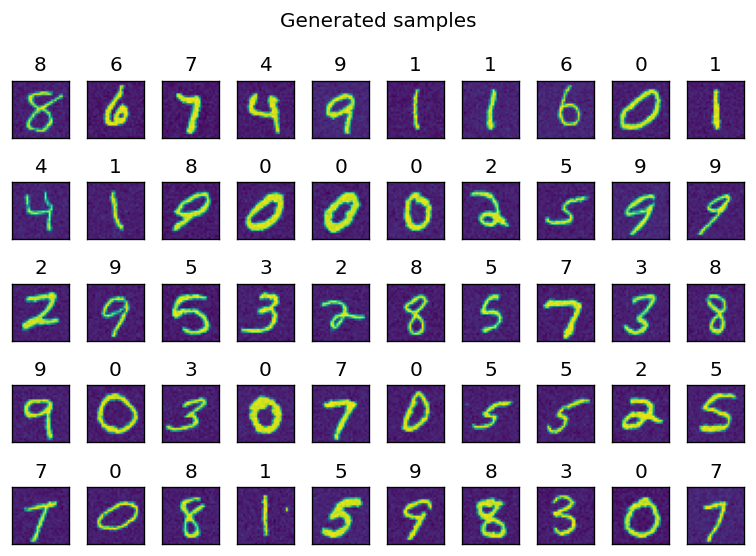

In [7]:
plotimages(sigmoid.(x_0), y_0 .- 1, "Generated samples");